# Adhering to constraints

This notebook explains our approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

Again, we will use the same synthetic data from the past two user guides. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import utils as ap_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

RMSE at the constraints between the starting and true topography: 0.14 m


returning original grid
returning original grid


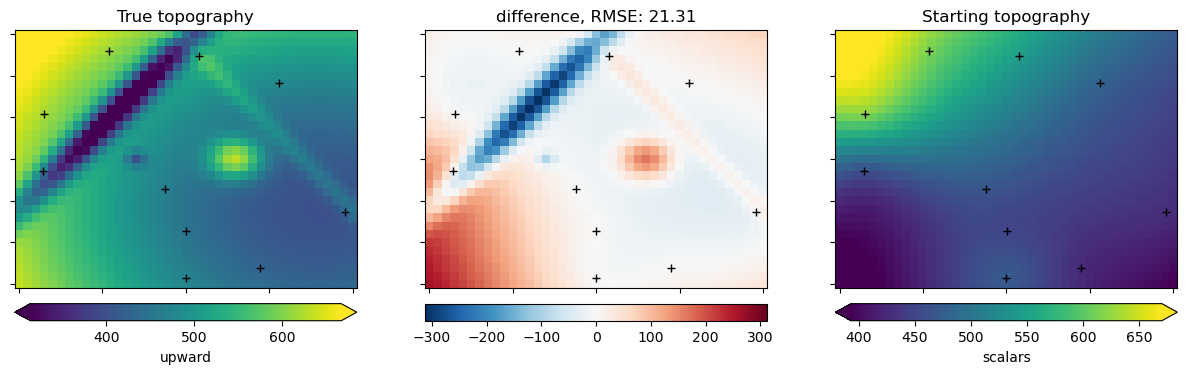

In [4]:
_ = ap_utils.grd_compare(
    true_topography,
    starting_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [7]:
# for a reference level we use the mean value of the starting model
zref = starting_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,-6.537446,16.072089,0,16.072089
1,0.0,1000.0,1000.0,10.422834,-7.742933,18.165768,0,18.165768
2,0.0,2000.0,1000.0,9.949973,-7.851638,17.801611,0,17.801611
3,0.0,3000.0,1000.0,9.269279,-7.723797,16.993076,0,16.993076
4,0.0,4000.0,1000.0,8.532160,-7.492407,16.024567,0,16.024567
...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,-0.019163,3.351879,0,3.351879
1267,30000.0,37000.0,1000.0,3.330307,-0.297847,3.628154,0,3.628154
1268,30000.0,38000.0,1000.0,3.335438,-0.557034,3.892471,0,3.892471
1269,30000.0,39000.0,1000.0,3.300721,-0.776698,4.077419,0,4.077419


## Weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

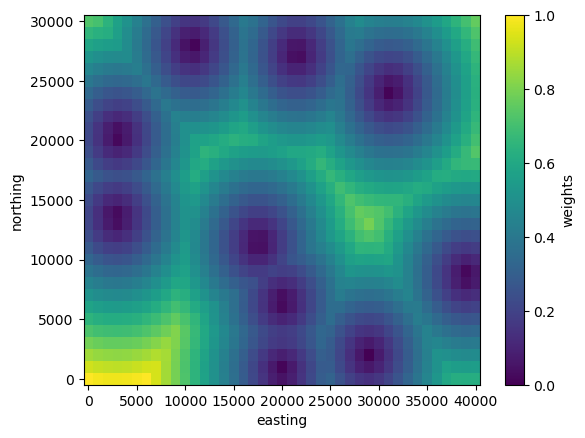

In [8]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

## Perform inversion
Now we can perform the inversion, supplied the argument `weights_after_solving=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 10 to 20. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1


INFO:root:Layer correction median: -10.3078 m, RMSE:99.5889 m
INFO:root:updated misfit RMSE: 2.9025
INFO:root:updated L2-norm: 1.7037, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.5599, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 5.8383 m, RMSE:43.0472 m
INFO:root:updated misfit RMSE: 1.6872
INFO:root:updated L2-norm: 1.2989, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.3116, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 3.484 m, RMSE:26.0473 m
INFO:root:updated misfit RMSE: 1.1061
INFO:root:updated L2-norm: 1.0517, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.235, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 1.463 m, RMSE:17.7758 m
INFO:root:updated misfit RMSE: 0.7851
INFO:root:updated L2-norm: 0.8861, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.187, toler

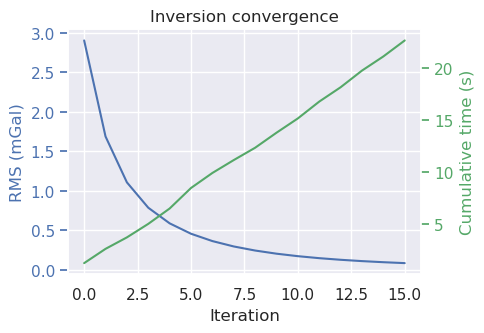

In [13]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.01,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.3,
    delta_l2_norm_tolerance=1.01,
    # enable the use of weights
    weights_after_solving=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


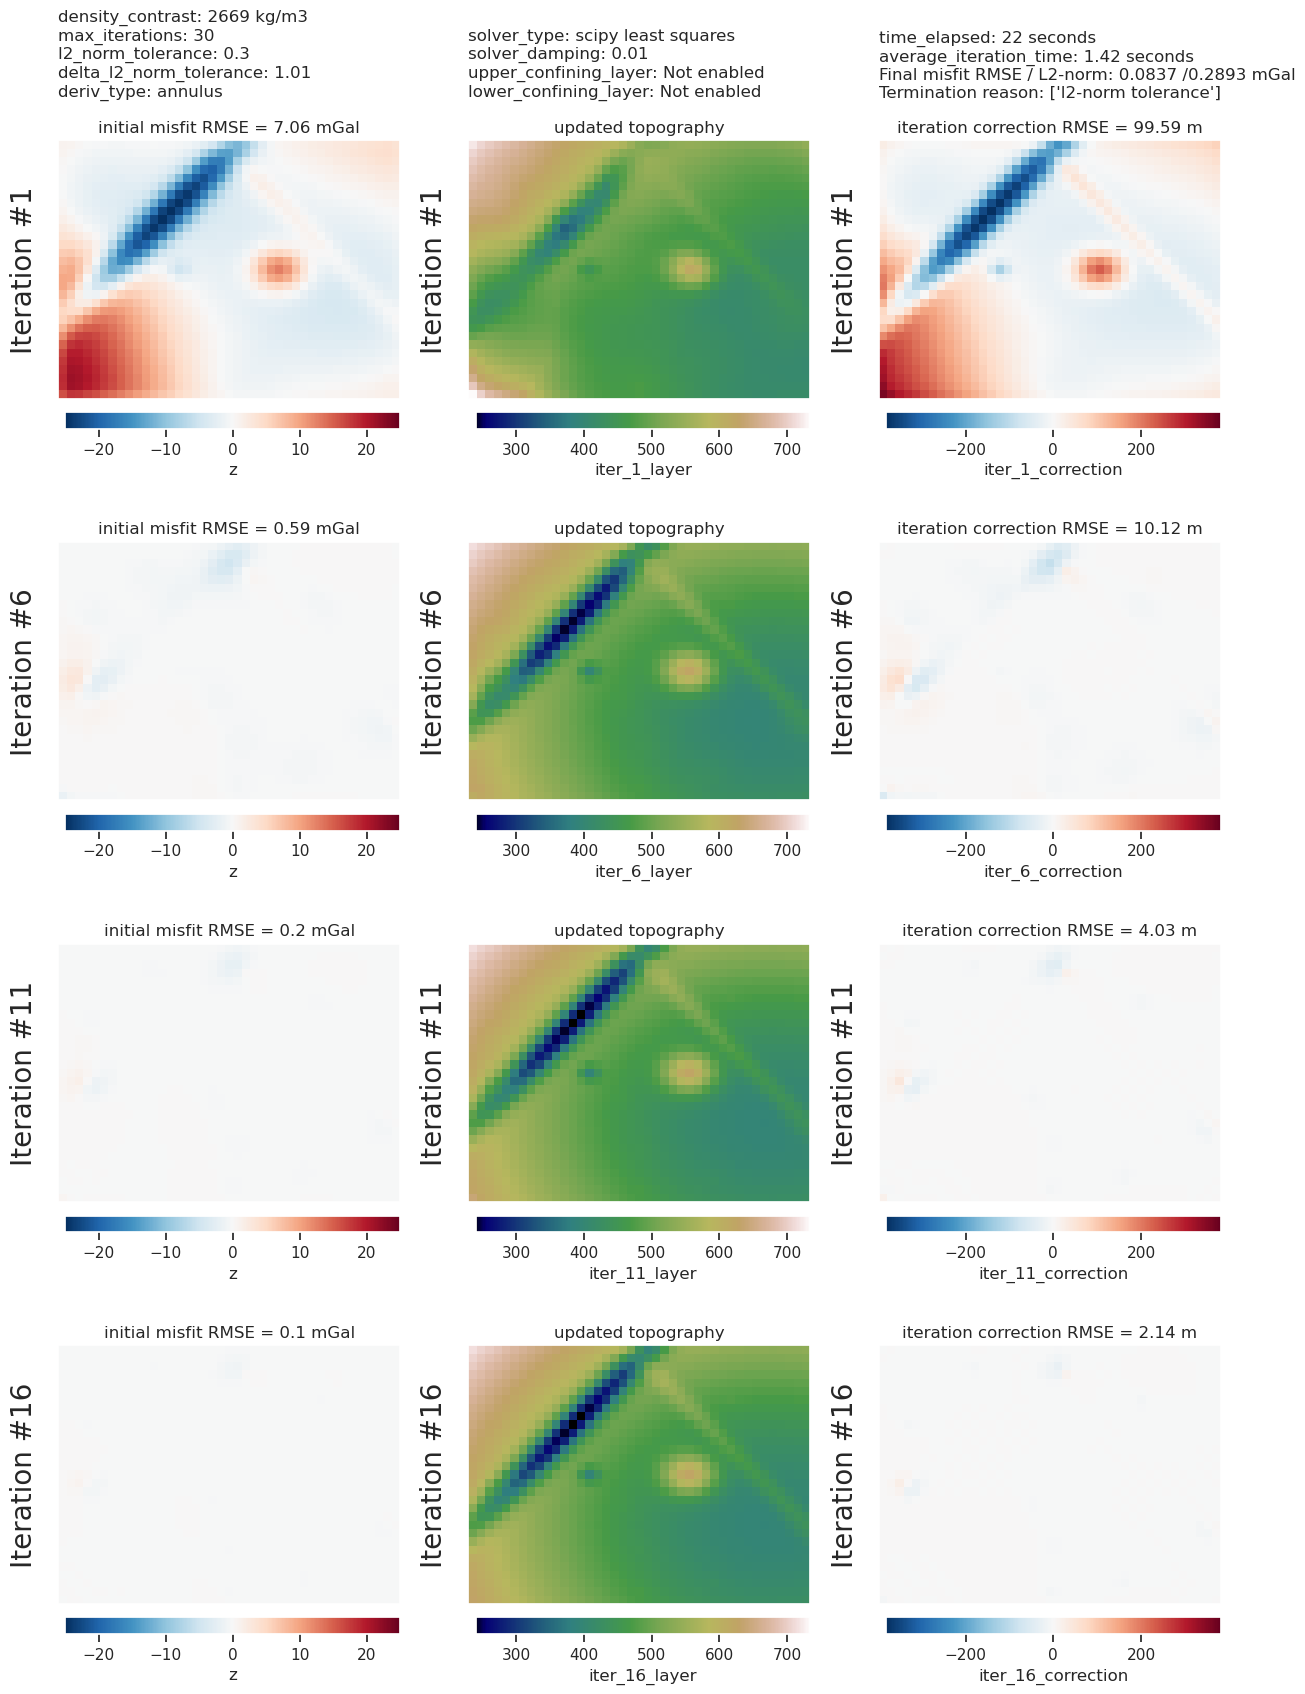

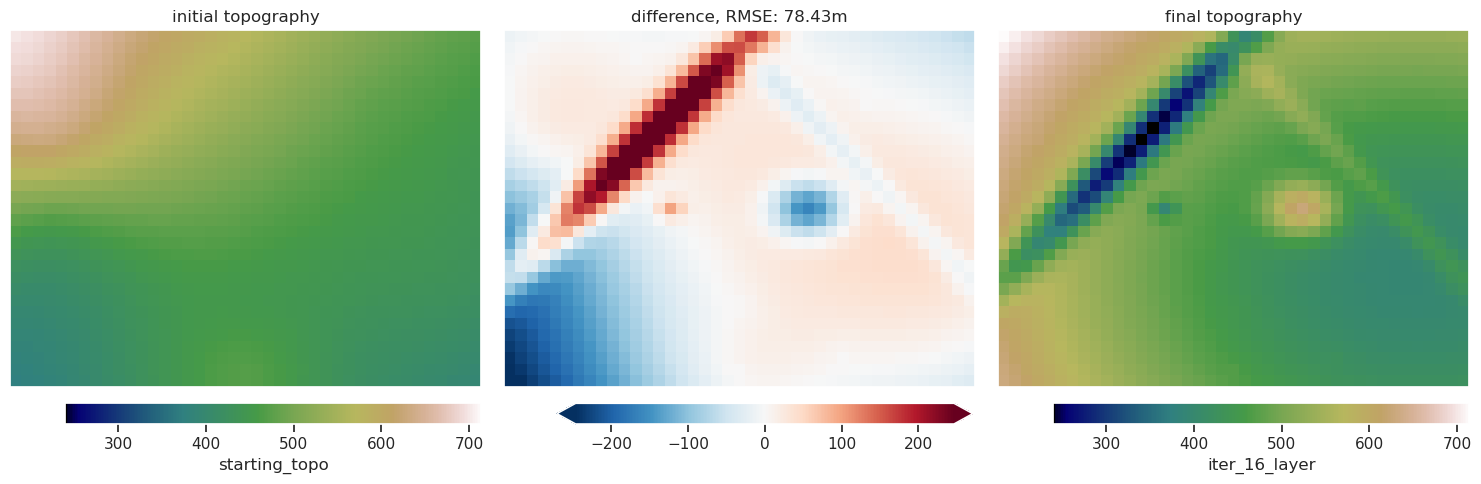

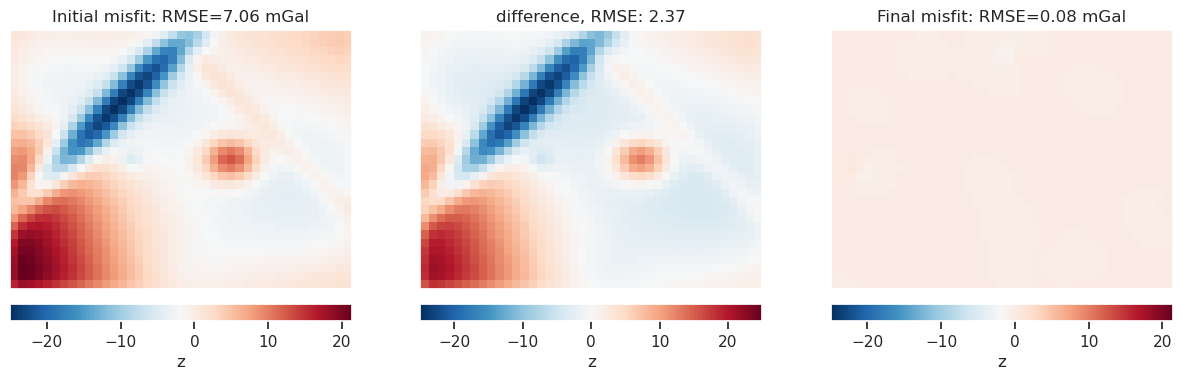

In [14]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


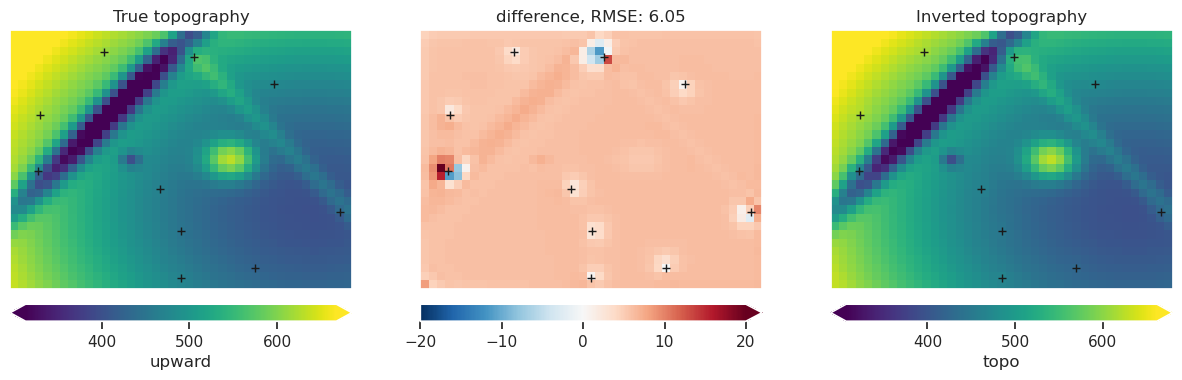

In [15]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

As we can see by the low error values surround the constraints (black crosses), include the weighting grid has help the inversion adhere to the constraints. We can sample the inverted topography at the constraints and compare with the constraints true values.

In [16]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 2.44 m


#